In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

In [4]:
#load data object: prenatal skin only, post qc

fskin_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fskin_path = root_path + fskin_object
adata = sc.read(fskin_path)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [5]:
adata

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202'
  

In [6]:
#check annotations

print(list(adata.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neuron pr

In [7]:
#re-order annotations

adata.obs['joint_annotation_20220202'] = adata.obs['joint_annotation_20220202'].cat.reorder_categories([
'Periderm',
'Immature basal', 
'Immature suprabasal',
'POSTN+ basal',
'DPYSL2+ basal',
'Suprabasal IFE', 
'Outer root sheath',
'Companion layer',
'Placode/matrix',
'Inner root sheath',
'Cuticle/cortex',
'Melanocyte', 
'Melanoblast',     
'Adipocytes',
'FRZB+ early fibroblast',
'HOXC5+ early fibroblast',
'WNT2+ fibroblast',
'PEAR1+ fibroblast',
'Pre-dermal condensate',
'Dermal condensate', 
'Dermal papilla',
'Myofibroblasts',
'Myoblasts',
'Early myocytes',  
'Myocytes',
'Pericytes',
'LMCD1+ mural cell',
'PLN+ mural cell',
'Neuroendocrine',
'Neuron progenitors',
'SPP1+ proliferating neuron progenitors',
'PID1+ schwann cellls',
'Schwann/Schwann precursors', 
'Myelinating Schwann cells', 
'ASDC',
'DC1',
'DC2',
'Inflammatory DC',
'pDC',
'LC',
'Monocyte precursor', 
'Monocyte',   
'Monocyte (activated/differentiating)',
'Iron-recycling macrophage', 
'LYVE1++ macrophage', 
'MHCII+ macrophage',
'TREM2+ macrophage',
'Neutrophil1',
'Neutrophil2',
'Lymphoid progenitor',
'LTi',
'ILC2', 
'ILC3', 
'Innate T type1', 
'Innate T type3', 
'NK cell',
'CD4 T cell',
'CD8 T cell',
'Treg',
'Pre B cell', 
'Pre pro B cell',
'Pro B cell', 
'B cell',
'HSC',
'Erythroid (embryonic)',
'Early erythroid (embryonic)', 
'Early erythroid',
'Erythroid (fetal)',  
'MEMP - Early erythroid',
'MEMP - Megak',
'Megakaryocyte',
'Eo/baso/mast cell progenitor',
'Mast cell (earliest)',
'Mast cell (most mature)', 
'Mast cell (medium)',
'Early LE', 
'LE',
'Early endothelial cells',
'Capillary arterioles',
'Arterioles',
'Capillaries',
'Postcapillary venules',
'Venules'])

In [8]:
adata.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,independent_annotation_broad1_20220201,independent_annotation_broad2_20220201,independent_annotation_broad3_20220201,joint_annotation_20220201a,joint_annotation_20220201b,fig1b_annotation_20220201,fig1b_annotation_20220202,joint_annotation_20220202,fig1b_annotation_v2,independent_annotation_refined_20220202
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,Macrophage,LYVE1++ macrophage,Macrophage,LYVE1++ macrophage
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,Monocyte,Monocyte,Monocyte,Monocyte (activated/differentiating),Monocyte (activated/differentiating),Monocyte,Monocyte,Monocyte (activated/differentiating),Monocyte,Monocyte (activated/differentiating)
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,Macrophage,LYVE1++ macrophage,Macrophage,LYVE1++ macrophage
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,Granulocyte progenitor,Granulocyte progenitor,Granulocyte progenitor,Eo/baso/mast cell progenitor,Eo/baso/mast cell progenitor,Progenitor,Progenitor,Eo/baso/mast cell progenitor,Haem progenitor,Eo/baso/mast cell progenitor
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,Macrophage,LYVE1++ macrophage,Macrophage,LYVE1++ macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,Mural cell,Mural cell,Mural cell,Pericytes,Pericytes,Mural cell,Mural cell,Pericytes,Mural cell,Pericytes
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.125778,...,Mural cell,Mural cell,Mural cell,Pericytes,Pericytes,Mural cell,Mural cell,Pericytes,Mural cell,Pericytes
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,Early erythroid,Erythroid,Erythroid,Early erythroid,Early erythroid,Erythroid,Erythroid,Early erythroid,Erythroid,Early erythroid


In [9]:
display(adata.obs.groupby(['donor', 'pcw', 'sample']).apply(len))

donor  pcw  sample            
F16    8    F16_male_8+1PCW         837
F17    9    F17_male_9+1PCW        2080
F19    10   F19_female_10+2PCW     5231
F32    7    F32_female_7+6PCW      9768
F33    9    F33_female_9+5PCW     13230
F34    8    F34_female_8+1PCW     12804
F35    7    F35_female_7+6PCW      7923
F38    13   F38_male_13+6PCW      13434
F41    16   F41_female_16PCW       6071
F45    12   F45_female_12PCW       7211
F50    15   F50_SK_CD45N_1         6435
            F50_SK_CD45N_2         5684
            F50_SK_CD45P_5         3653
            F50_SK_CD45P_6         4737
F51    15   F51_SK_CD45N_1         7369
            F51_SK_CD45N_2         6161
            F51_SK_CD45P_5         6809
            F51_SK_CD45P_6         5808
F61    7    F61_SK_CD45N_1         6854
            F61_SK_CD45N_2         7230
            F61_SK_CD45P_1         2790
F69    11   F69-GEX_4_SKI_45P      3012
            F69-GEX_5_SKI_45N      6483
            F69-GEX_6_SKI_45N      5774
         

# Plot umap

In [10]:
adata

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202'
  

<AxesSubplot: title={'center': 'fig1b_annotation_v2'}, xlabel='umap21', ylabel='umap22'>

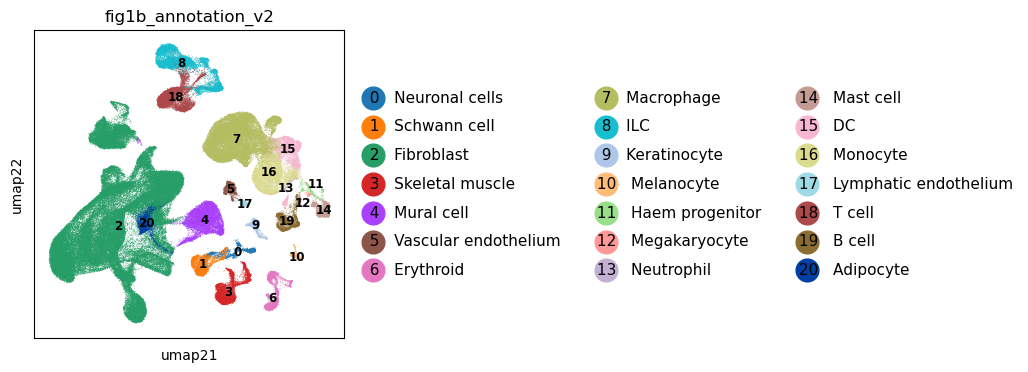

In [11]:
sk.set_figsize((5, 5))
sk.plot_embedding(adata,
    basis="umap2",
    groupby="fig1b_annotation_v2",
    size=1,
    legend_fontsize=10)

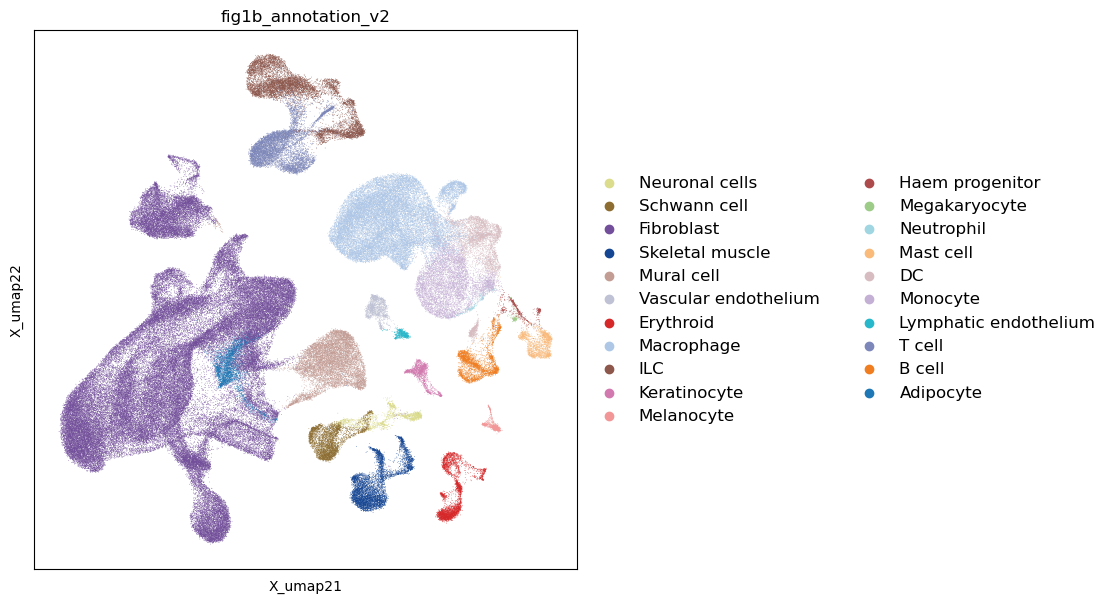

In [12]:
sk.set_figsize((7, 7))
sc.pl.embedding(adata,
    basis="X_umap2",
    color="fig1b_annotation_v2",
    size=1,
    legend_fontsize=12,
    palette={
        'Neuronal cells': '#DCDC8D',   
        'Schwann cell': '#8D6D31',
        'Fibroblast': '#734F9B',
        'Skeletal muscle': '#154694', 
        'Mural cell': '#C39C94', 
        'Vascular endothelium': '#BFC2D4', 
        'Erythroid': '#D62729',
        'Macrophage': '#AEC7E7',
        'ILC': '#8D574C',
        'Keratinocyte': '#D279AF', 
        'Melanocyte': '#F29697',
        'Haem progenitor': '#AD4A4B',
        'Megakaryocyte': '#9DCB88', 
        'Neutrophil': '#9FD6E2',
        'Mast cell': '#F9BA7A',   
        'DC': '#D7BCC1',
        'Monocyte': '#C5B0D5', 
        'Lymphatic endothelium': '#28B8CB',
        'T cell': '#7D87B9',
        'B cell': '#F07E20',    
        'Adipocyte': '#1E78B5'},
        save= 'Fig1_umap1.pdf')

# plot umap pooled prenatal skin, adult skin and skin organoid

In [13]:
#"/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/pooled_fetal_organoid_adult.processed.h5ad"

pooled_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/pooled_fetal_organoid_adult.processed.h5ad'
pooled_ad = sc.read(pooled_path)

In [14]:
pooled_ad

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_

In [15]:
pooled_ad.obs.dataset.unique()

['fetal', 'organoid', 'adult']
Categories (3, object): ['fetal', 'organoid', 'adult']

<AxesSubplot: title={'center': 'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

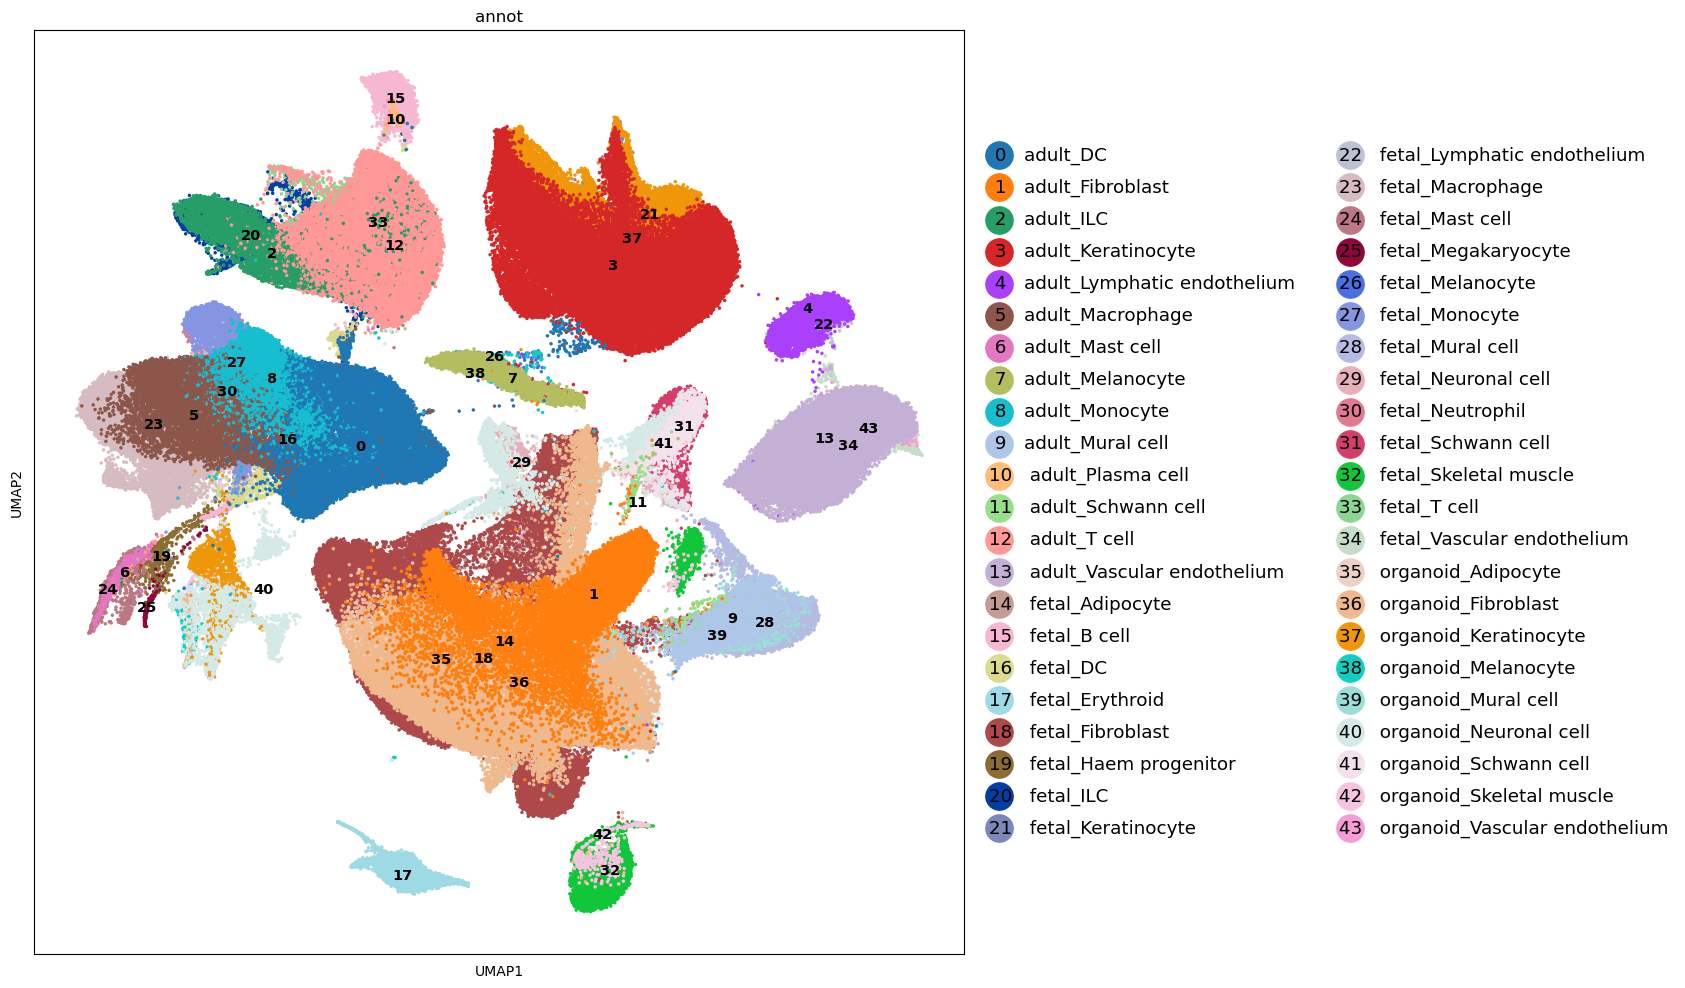

In [16]:
sk.plot_embedding(pooled_ad,
    basis="umap",
    groupby="annot",
    size=25,
    legend_fontsize=12,
    figsize=(12, 12))

<AxesSubplot: title={'center': 'dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

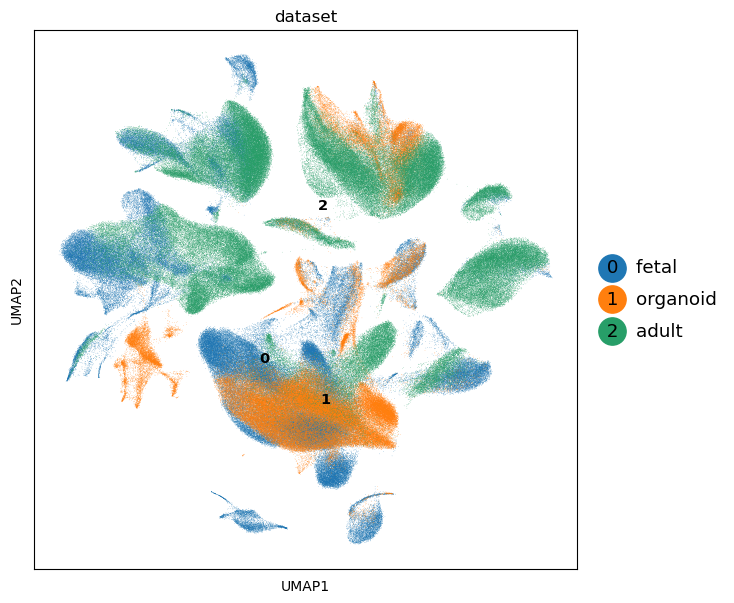

In [17]:
#colour by dataset
sk.plot_embedding(pooled_ad,
    basis="umap",
    groupby="dataset",
    size=0.5,
    legend_fontsize=12,
    figsize=(7, 7))

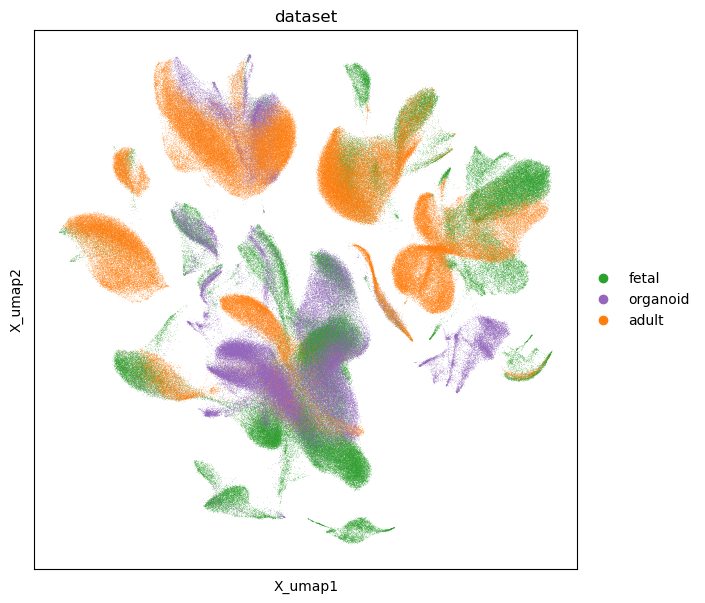

In [19]:
#sk.set_figsize((7,7))
#sc.pl.embedding(pooled_ad, basis='X_umap', color=['dataset'], s=0.5,
#                      palette={'fetal': 'tab:green',
#                                'organoid': 'tab:purple', 
#                                'adult': 'tab:orange'},
#                save= 'Fig5_combined_umap.pdf')

In [18]:
print(list(pooled_ad.obs['annot'].unique()))

['fetal_Macrophage', 'fetal_Monocyte', 'fetal_Haem progenitor', 'fetal_DC', 'fetal_Fibroblast', 'fetal_ILC', 'fetal_B cell', 'fetal_T cell', 'fetal_Lymphatic endothelium', 'fetal_Skeletal muscle', 'fetal_Mast cell', 'fetal_Vascular endothelium', 'fetal_Neutrophil', 'fetal_Megakaryocyte', 'fetal_Erythroid', 'fetal_Mural cell', 'fetal_Neuronal cell', 'fetal_Schwann cell', 'fetal_Adipocyte', 'fetal_Keratinocyte', 'fetal_Melanocyte', 'organoid_Fibroblast', 'organoid_Keratinocyte', 'organoid_Adipocyte', 'organoid_Mural cell', 'organoid_Melanocyte', 'organoid_Neuronal cell', 'organoid_Schwann cell', 'organoid_Skeletal muscle', 'organoid_Vascular endothelium', 'adult_Keratinocyte', 'adult_Melanocyte', 'adult_Lymphatic endothelium', 'adult_Fibroblast', 'adult_DC', 'adult_T cell', 'adult_Vascular endothelium', 'adult_ILC', 'adult_Macrophage', 'adult_Plasma cell', 'adult_Monocyte', 'adult_Mural cell', 'adult_Schwann cell', 'adult_Mast cell']


In [19]:
pooled_ad.obs['broad_integrated'] = pooled_ad.obs['annot']

In [20]:
pooled_ad.obs.broad_integrated.replace({
'fetal_Macrophage': 'immune',
'fetal_Monocyte': 'immune', 
'fetal_Haem progenitor': 'immune',
'fetal_DC': 'immune',
'fetal_Fibroblast': 'dermal stroma',
'fetal_ILC': 'immune',
'fetal_B cell': 'immune',
'fetal_T cell': 'immune',
'fetal_Lymphatic endothelium': 'endothelium',
'fetal_Skeletal muscle': 'dermal stroma',
'fetal_Mast cell': 'immune',
'fetal_Vascular endothelium': 'endothelium',
'fetal_Neutrophil': 'immune',
'fetal_Langerhans cell': 'immune',
'fetal_Megakaryocyte': 'immune',
'fetal_Erythroid': 'erythroid',  
'fetal_Mural cell': 'dermal stroma', 
'fetal_Neuronal cell': 'neuronal', 
'fetal_Schwann cell': 'neuronal', 
'fetal_Adipocyte': 'dermal stroma', 
'fetal_Keratinocyte': 'epidermis', 
'fetal_Melanocyte': 'melanocyte', 
'organoid_Fibroblast': 'dermal stroma', 
'organoid_Keratinocyte': 'epidermis', 
'organoid_Adipocyte': 'dermal stroma', 
#'organoid_Dermal papillia': 'dermal stroma', 
'organoid_Mural cell': 'dermal stroma', 
'organoid_Melanocyte': 'melanocyte', 
'organoid_Neuronal cell': 'neuronal', 
'organoid_Schwann cell': 'neuronal', 
'organoid_Skeletal muscle': 'dermal stroma', 
'organoid_Vascular endothelium': 'endothelium',
'adult_Keratinocyte': 'epidermis', 
'adult_Melanocyte': 'melanocyte', 
'adult_Lymphatic endothelium': 'endothelium',
'adult_Fibroblast': 'dermal stroma',
'adult_DC': 'immune',
'adult_T cell': 'immune',
'adult_Vascular endothelium': 'endothelium',
'adult_ILC': 'immune',
'adult_Macrophage': 'immune',
'adult_Plasma cell': 'immune',
'adult_Monocyte': 'immune',
'adult_Mural cell': 'dermal stroma', 
'adult_Schwann cell': 'neuronal',
'adult_Mast cell': 'immune'
}, inplace=True)

In [21]:
pooled_ad_fs = pooled_ad[pooled_ad.obs['dataset'] == "fetal"]
pooled_ad_or = pooled_ad[pooled_ad.obs['dataset'] == "organoid"]
pooled_ad_at = pooled_ad[pooled_ad.obs['dataset'] == "adult"]

(-9.467181587219239, 27.06060733795166)

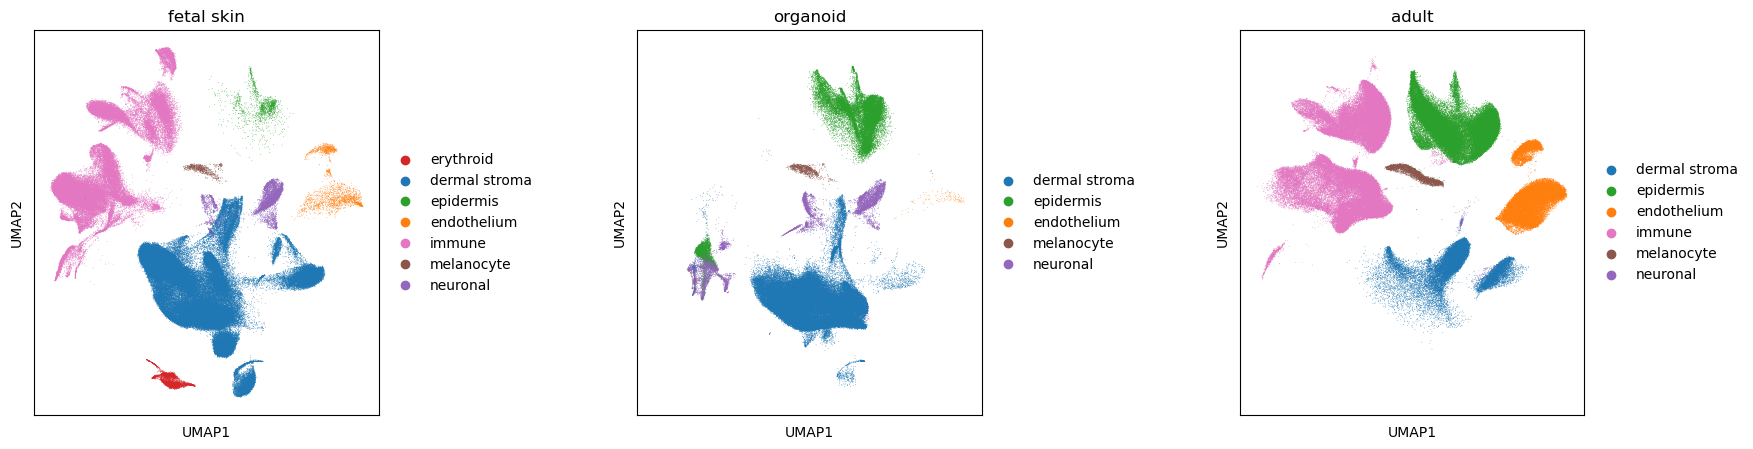

In [22]:
sk.set_figsize((20, 5))
fig = plt.figure()
spec = fig.add_gridspec(ncols=3, nrows=1)
spec.update(wspace=0.75, hspace=0.1) # set the spacing between axes.

f1 = fig.add_subplot(spec[0,0])
f2 = fig.add_subplot(spec[0,1])
f3 = fig.add_subplot(spec[0,2])

fig1 = sc.pl.embedding(pooled_ad_fs, basis='X_umap', color=['broad_integrated'], s=1, show=False, ax=f1, title='fetal skin',
                      palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'})
f1.set(xlabel="UMAP1", ylabel="UMAP2")

fig2 = sc.pl.embedding(pooled_ad_or, basis='X_umap', color=['broad_integrated'], s=1, show=False, ax=f2, title='organoid',
                      palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'})
f2.set(xlabel="UMAP1", ylabel="UMAP2")

fig3 = sc.pl.embedding(pooled_ad_at, basis='X_umap', color=['broad_integrated'], s=1, show=False, ax=f3, title='adult',
                        palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'})
f3.set(xlabel="UMAP1", ylabel="UMAP2")

f2.set_xlim((f1.get_xlim()))
f2.set_ylim((f1.get_ylim()))
f3.set_xlim((f1.get_xlim()))
f3.set_ylim((f1.get_ylim()))

#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig1_split_umaps2.pdf", bbox_inches="tight")

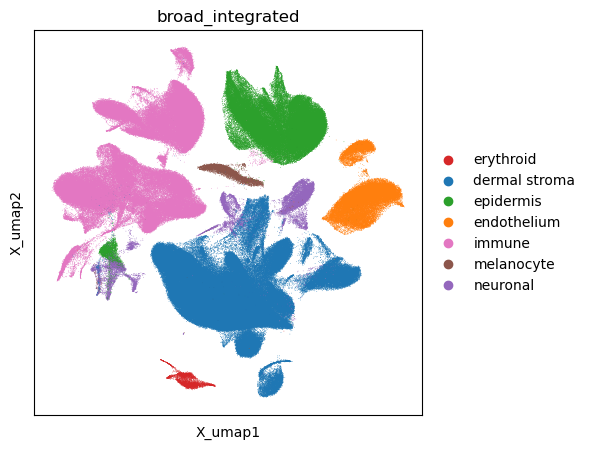

In [25]:
sk.set_figsize((5, 5))
sc.pl.embedding(pooled_ad, basis='X_umap', color=['broad_integrated'], s=1,
                      palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'},
               save = 'integrated_umap_broad1.pdf')

In [26]:
print(pooled_ad.obs['broad_integrated'].cat.categories)

Index(['erythroid', 'dermal stroma', 'epidermis', 'endothelium', 'immune',
       'melanocyte', 'neuronal'],
      dtype='object')


In [27]:
# now set colour values:
pooled_ad.uns['broad_integrated_colors'] = ['tab:red',
                                         'tab:blue', 
                                         'tab:green',
                                         'tab:orange',
                                         'tab:pink' ,
                                         'tab:brown',
                                         'tab:purple']

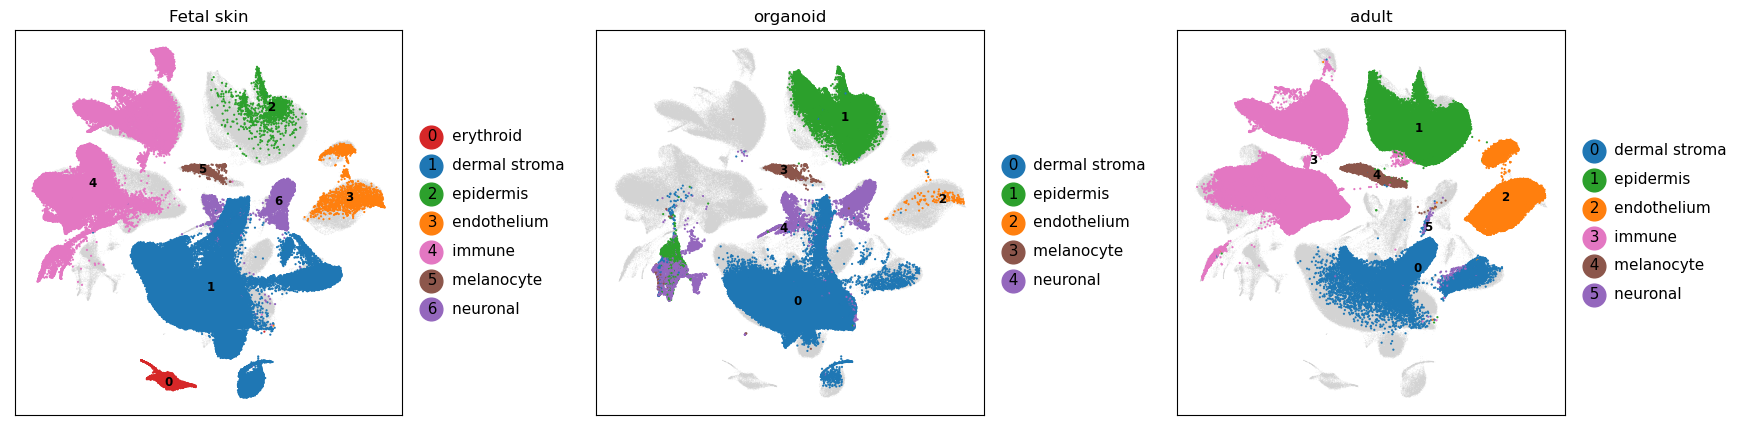

In [29]:
sk.set_figsize((20, 5))
fig, axs = plt.subplots(nrows=1, ncols=3, gridspec_kw={"wspace": 0.5})

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[0])
sk.plot_embedding(pooled_ad_fs,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",           
    title="Fetal skin",
    ax=axs[0],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[1])
sk.plot_embedding(pooled_ad_or,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    title="organoid",
    ax=axs[1],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[2])
sk.plot_embedding(pooled_ad_at,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    title="adult",
    ax=axs[2],
    show=False)

axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_ylabel("")
#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig1_split_umaps2.pdf", bbox_inches="tight")
gc.collect();

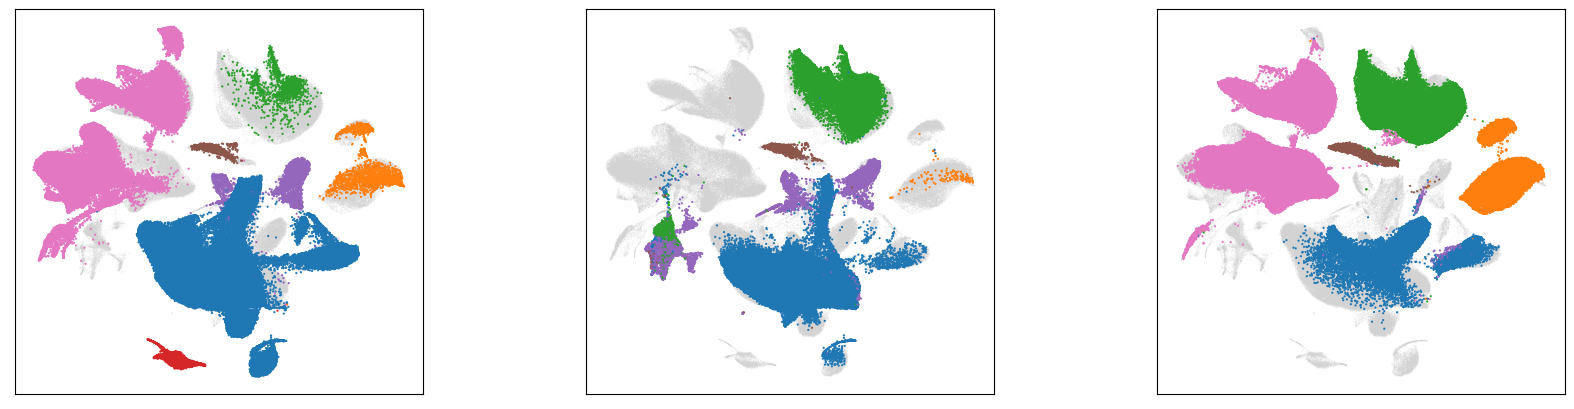

In [30]:
sk.set_figsize((20, 5))
fig, axs = plt.subplots(nrows=1, ncols=3, gridspec_kw={"wspace": 0.4})

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[0])
sk.plot_embedding(pooled_ad_fs,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    annot=False,            
    title="Fetal skin",
    ax=axs[0],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[1])
sk.plot_embedding(pooled_ad_or,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    annot=False,
    title="organoid",
    ax=axs[1],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[2])
sk.plot_embedding(pooled_ad_at,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    annot=False,
    title="adult",
    ax=axs[2],
    show=False)

axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_ylabel("")
fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig1_split_umaps2_noannot3_26062023.pdf", bbox_inches="tight")
gc.collect();